In [1]:
import transformer_lens
import plotly.io as pio
import circuitsvis as cv

# Set the default renderer for Plotly:
pio.renderers.default = "png"

# Testing that the library works
cv.examples.hello("Ajay")

In [2]:
# Import stuff
import torch
import torch.nn as nn
import tqdm.auto as tqdm
from functools import partial

# Flexible and powerful tensor operations for readable and reliable code. Supports numpy, pytorch, tensorflow, jax, and others.
import einops

# Drop-in replacement for torch/numpy einsum, with descriptive variable names in equations
# https://stackoverflow.com/questions/26089893/understanding-numpys-einsum
from fancy_einsum import einsum 

# The plotly.express module (usually imported as px) contains functions that can create entire figures at once, and is referred to as Plotly Express or PX
import plotly.express as px 

# https://github.com/jax-ml/jax
# https://github.com/patrick-kidger/jaxtyping
from jaxtyping import Float

In [3]:
# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)

In [5]:
# Plotting Helper Functions
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [6]:
device = utils.get_device()
print("Device:", device)
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Device: mps
Loaded pretrained model gpt2-small into HookedTransformer


In [7]:
# Loading and Running Models
model_description_text = """## Loading Models

HookedTransformer comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. See my explainer for documentation of all supported models, and this table for hyper-parameters and the name used to load them. Each model is loaded into the consistent HookedTransformer architecture, designed to be clean, consistent and interpretability-friendly. 

For this demo notebook we'll look at GPT-2 Small, an 80M parameter model. To try the model the model out, let's find the loss on this paragraph!"""
loss = model(model_description_text, return_type="loss")
print("Model loss:", loss)

Model loss: tensor(4.1758, device='mps:0')


In [8]:
# Caching all Activations
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = model.to_tokens(gpt2_text) # Converts a string to a tensor of tokens.
print(gpt2_tokens.device)
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

mps:0


In [9]:
print(type(gpt2_cache))
attention_pattern = gpt2_cache["pattern", 0, "attn"]
print(attention_pattern.shape)
gpt2_str_tokens = model.to_str_tokens(gpt2_text)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 33, 33])


In [10]:
print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

Layer 0 Head Attention Patterns:


The key feature here is hook points. Every activation inside the transformer is surrounded by a hook point, which allows us to edit or intervene on it
We do this by adding a hook function to that activation. The hook function maps `current_activation_value`, `hook_point` to `new_activation_value`. As the model is run, it computes that activation as normal, and then the hook function is applied to compute a replacement, and that is substituted in for the activation. The hook function can be an arbitrary Python function, so long as it returns a tensor of the correct shape.

In [11]:
layer_to_ablate = 0
head_index_to_ablate = 8

# We define a head ablation hook
# The type annotations are NOT necessary, they're just a useful guide to the reader
# 
def head_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    print(f"Shape of the value tensor: {value.shape}")
    value[:, :, head_index_to_ablate, :] = 0.
    return value

original_loss = model(gpt2_tokens, return_type="loss")
ablated_loss = model.run_with_hooks(
    gpt2_tokens, 
    return_type="loss", 
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate), 
        head_ablation_hook
        )]
    )
print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss: {ablated_loss.item():.3f}")

Shape of the value tensor: torch.Size([1, 33, 12, 64])
Original Loss: 3.999
Ablated Loss: 5.453


**Gotcha:** Hooks are global state - they're added in as part of the model, and stay there until removed. `run_with_hooks` tries to create an abstraction where these are local state, by removing all hooks at the end of the function. But you can easily shoot yourself in the foot if there's, eg, an error in one of your hooks so the function never finishes. If you start getting bugs, try `model.reset_hooks()` to clean things up. Further, if you *do* add hooks of your own that you want to keep, which you can do with `add_perma_hook` on the relevant HookPoint

## Activation Patching on the IOI Task
See explanation: [Activation Patching - dynalist.io](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx)

In [12]:
clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    # model.to_single_token maps a string value of a single token to the token index for that token
    # If the string is not a single token, it raises an error.
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

# We don't need to cache on the corrupted prompt.
corrupted_logits = model(corrupted_tokens)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

Clean logit difference: 4.276
Corrupted logit difference: -2.738


We now setup the hook function to do activation patching. Here, we'll patch in the [residual stream](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=DHp9vZ0h9lA9OCrzG2Y3rrzH) at the start of a specific layer and at a specific position. This will let us see how much the model is using the residual stream at that layer and position to represent the key information for the task. 

We want to iterate over all layers and positions, so we write the hook to take in an position parameter. Hook functions must have the input signature (activation, hook), but we can use `functools.partial` to set the position parameter before passing it to `run_with_hooks`

In [13]:
# We define a residual stream patching hook
# We choose to act on the residual stream at the start of the layer, so we call it resid_pre
# The type annotations are a guide to the reader and are not necessary
def residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
    position: int
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    clean_resid_pre = clean_cache[hook.name]
    resid_pre[:, position, :] = clean_resid_pre[:, position, :]
    return resid_pre

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
num_positions = len(clean_tokens[0])
ioi_patching_result = torch.zeros((model.cfg.n_layers, num_positions), device=model.cfg.device)

for layer in tqdm.tqdm(range(model.cfg.n_layers)):
    for position in range(num_positions):
        # Use functools.partial to create a temporary hook function with the position fixed
        temp_hook_fn = partial(residual_stream_patching_hook, position=position)
        # Run the model with the patching hook
        patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=[
            (utils.get_act_name("resid_pre", layer), temp_hook_fn)
        ])
        # Calculate the logit difference
        patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
        # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
        ioi_patching_result[layer, position] = (patched_logit_diff - corrupted_logit_diff)/(clean_logit_diff - corrupted_logit_diff)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/12 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


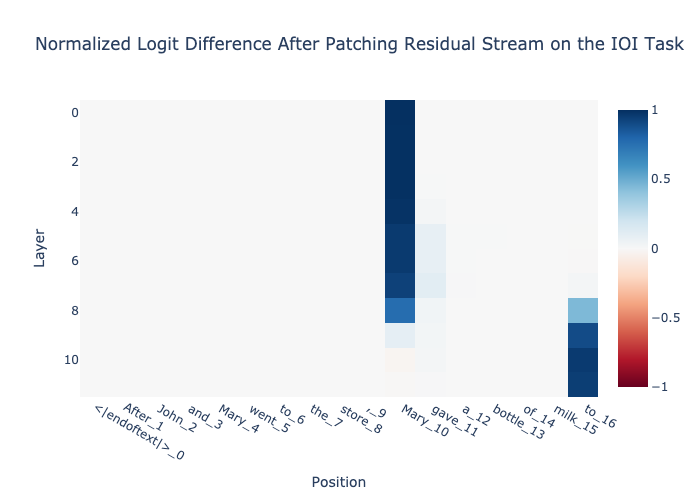

In [14]:
# Add the index to the end of the label, because plotly doesn't like duplicate labels
token_labels = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(clean_tokens))]
imshow(ioi_patching_result, x=token_labels, xaxis="Position", yaxis="Layer", title="Normalized Logit Difference After Patching Residual Stream on the IOI Task")